In [5]:

from pycaret.regression import *
import matplotlib.pyplot as plt


#https://pycaret.gitbook.io/docs/learn-pycaret/official-blog/time-series-101-for-beginners

In [2]:
import pandas as pd
data=pd.read_excel('/home/ykkim/Train_data/무림페이퍼_15분사용전력_210401-220630.xlsx')  
data=data.drop(['등록시각'],axis=1)

data['기준시각']=pd.to_datetime(data['기준시각'])
data.info()
len(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         42766 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 668.3 KB


42766

In [3]:
#이상치 제거
# 5100 이하값들은 이전 값들로 대체
import numpy as np
data.loc[(data['직전 15분 사용전력'] <= 5100),'직전 15분 사용전력']= np.nan
data.isna().sum()
data=data.fillna(method='ffill')
data.isna().sum()

기준시각           0
직전 15분 사용전력    0
dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


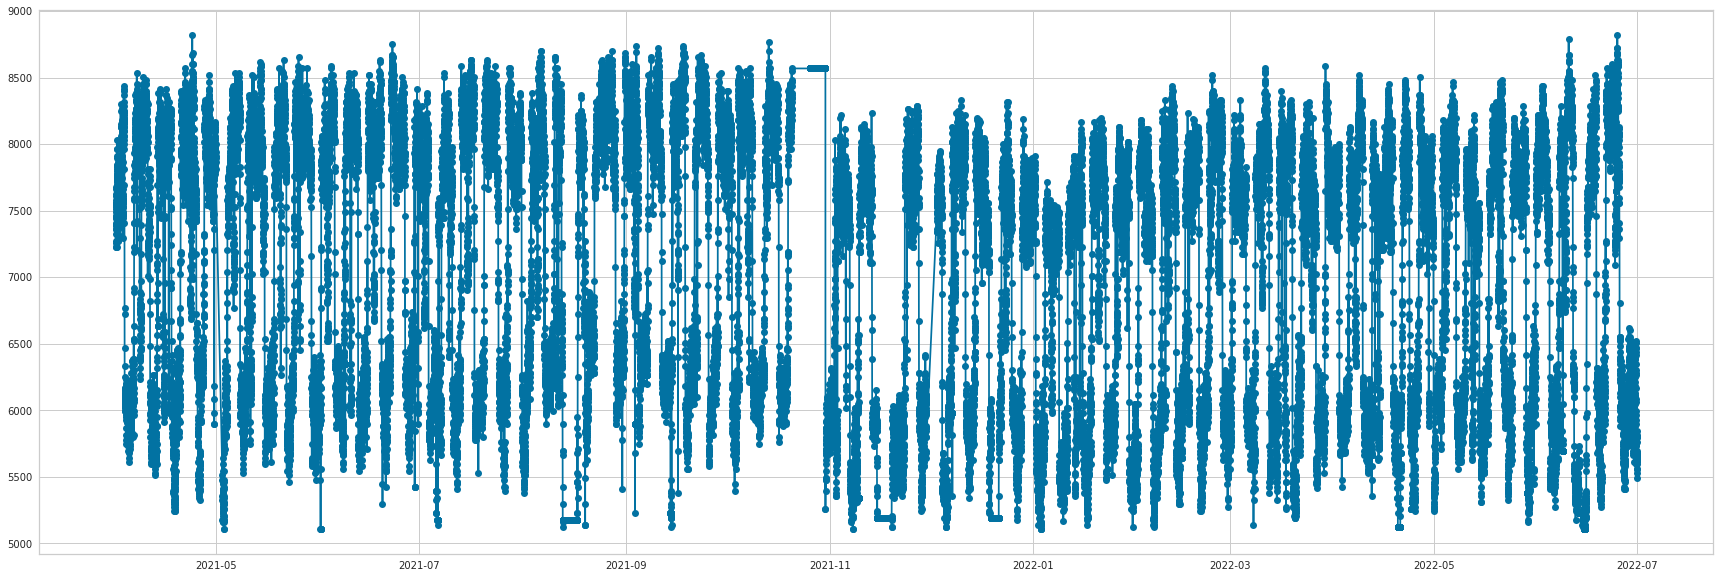

In [6]:
#plot
plt.figure(figsize=(30,10))
kws = dict(marker='o')
plt.plot(data['기준시각'],data['직전 15분 사용전력'], **kws)   
plt.legend()
plt.show()

In [8]:
#2. datetime을 feature(mon,day,hour,min,weekday)화  + lag
def date2features(data):
    data['year']=data['기준시각'].dt.year
    data['mon']=data['기준시각'].dt.month
    data['day']=data['기준시각'].dt.day
    data['hour']=data['기준시각'].dt.hour
    data['min']=data['기준시각'].dt.minute
    # data['weekday']=data['기준시각'].dt.weekday
    data=data.drop(['기준시각'], axis=1)
    data['lag1']=data['직전 15분 사용전력'].shift(1) 
    data['lag2']=data['직전 15분 사용전력'].shift(2) 
    data['lag3']=data['직전 15분 사용전력'].shift(3) 
    data['lag4']=data['직전 15분 사용전력'].shift(4) 
    data['lag5']=data['직전 15분 사용전력'].shift(5) 

    data['diff1']=data['직전 15분 사용전력'].diff(1).shift(1) 
    data['diff2']=data['직전 15분 사용전력'].diff(2).shift(1) 

    # data['Series']=data.index
    return data

In [9]:
#train_test split (Time Series)
def train_test_split(data,Time_name,train_cut_date,val_cut_date,end_time,want_val): # (data : dataframe , Time_name : 'dataframe 내 Time 변수명',want_val : validation set을 원할 경우'Y')

    data[Time_name]=pd.to_datetime(data[Time_name])
    df_train = data[data[Time_name] < train_cut_date ]
    df_test = data[(data[Time_name] >= val_cut_date) & (data[Time_name] <= end_time )] 
    print('train_df=',min(df_train[Time_name]),'~',max(df_train[Time_name]),',',len(df_train))
    print('test_df=',min(df_test[Time_name]),'~',max(df_test[Time_name]),',',len(df_test))

    if want_val=="Y":
        df_val= data[(data[Time_name] >= train_cut_date ) & (data[Time_name] < val_cut_date )]
        print('val_df=',min(df_val[Time_name]),'~',max(df_val[Time_name]),',',len(df_val))
        return (df_train,df_val,df_test) 

    return (df_train,df_test)  

#date to features

In [10]:
#train_test split
df_train,df_val,df_test=train_test_split(data,Time_name='기준시각',train_cut_date='2022-05-30',val_cut_date='2022-06-30',end_time='2022-06-30 23:45:00',want_val='Y')

train_df= 2021-04-01 00:00:00 ~ 2022-05-29 23:45:00 , 39694
test_df= 2022-06-30 00:00:00 ~ 2022-06-30 23:45:00 , 96
val_df= 2022-05-30 00:00:00 ~ 2022-06-29 23:45:00 , 2976


In [11]:
df_train

,기준시각,직전 15분 사용전력
0,2021-04-01 00:00:00,7224.0
1,2021-04-01 00:15:00,7274.4
2,2021-04-01 00:30:00,7442.4
3,2021-04-01 00:45:00,7392.0
4,2021-04-01 01:00:00,7576.8
...,...,...
39689,2022-05-29 22:45:00,5880.0
39690,2022-05-29 23:00:00,5964.0
39691,2022-05-29 23:15:00,5980.8
39692,2022-05-29 23:30:00,5846.4


In [12]:
df_train_t=date2features(df_train)
df_val_t=date2features(df_val)
df_train_t

,직전 15분 사용전력,year,mon,day,hour,min,lag1,lag2,lag3,lag4,lag5,diff1,diff2
0,7224.0,2021,4,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7274.4,2021,4,1,0,15,7224.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7442.4,2021,4,1,0,30,7274.4,7224.0,NaN,NaN,NaN,50.4,NaN
3,7392.0,2021,4,1,0,45,7442.4,7274.4,7224.0,NaN,NaN,168.0,218.4
4,7576.8,2021,4,1,1,0,7392.0,7442.4,7274.4,7224.0,NaN,-50.4,117.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39689,5880.0,2022,5,29,22,45,5863.2,5980.8,5997.6,5880.0,5863.2,-117.6,-134.4
39690,5964.0,2022,5,29,23,0,5880.0,5863.2,5980.8,5997.6,5880.0,16.8,-100.8
39691,5980.8,2022,5,29,23,15,5964.0,5880.0,5863.2,5980.8,5997.6,84.0,100.8
39692,5846.4,2022,5,29,23,30,5980.8,5964.0,5880.0,5863.2,5980.8,16.8,100.8


In [64]:
#missing data imputing(train)
df_train_t=df_train_t.fillna(method='bfill')
df_train_t

,직전 15분 사용전력,year,mon,day,hour,min,lag1,lag2,diff2
0,7224.0,2021,4,1,0,0,7224.0,7224.0,50.4
1,7274.4,2021,4,1,0,15,7224.0,7224.0,50.4
2,7442.4,2021,4,1,0,30,7274.4,7224.0,50.4
3,7392.0,2021,4,1,0,45,7442.4,7274.4,168.0
4,7576.8,2021,4,1,1,0,7392.0,7442.4,-50.4
...,...,...,...,...,...,...,...,...,...
39689,5880.0,2022,5,29,22,45,5863.2,5980.8,-117.6
39690,5964.0,2022,5,29,23,0,5880.0,5863.2,16.8
39691,5980.8,2022,5,29,23,15,5964.0,5880.0,84.0
39692,5846.4,2022,5,29,23,30,5980.8,5964.0,16.8


In [13]:
# initialize setup**
s = setup(data = df_train_t, test_data = df_val_t, target = '직전 15분 사용전력', fold_strategy = 'timeseries', numeric_features = ['year','mon','day','hour', 'min','lag1','lag2','lag3','lag4','lag5','diff1','diff2'], fold = 5, transform_target = True, session_id = 123)

,Description,Value
0,session_id,123
1,Target,직전 15분 사용전력
2,Original Data,"(39694, 13)"
3,Missing Values,True
4,Numeric Features,12
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(39694, 12)"


In [14]:
#This function trains and evaluates the performance
# of all the estimators available in the model library
#  using cross-validation. 
# The output of this function is a scoring grid with average cross-validated scores. Metrics evaluated during CV can be accessed using the get_metrics function. Custom metrics can be added or removed using add_metric and remove_metric function.
best = compare_models(sort = 'MAPE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,86.9623,14924.5101,121.9745,0.9854,0.0179,0.0127,0.2860
gbr,Gradient Boosting Regressor,87.9139,15055.4728,122.5357,0.9852,0.0180,0.0128,2.0980
et,Extra Trees Regressor,94.0233,16970.0164,130.0441,0.9834,0.0192,0.0137,4.3620
catboost,CatBoost Regressor,93.4785,16416.9591,127.7902,0.9839,0.0190,0.0138,4.9140
rf,Random Forest Regressor,94.8003,17261.4577,131.0805,0.9831,0.0193,0.0139,7.7660
xgboost,Extreme Gradient Boosting,96.5496,17870.3086,133.2955,0.9825,0.0196,0.0141,1.4980
knn,K Neighbors Regressor,98.4743,18574.9825,136.0735,0.9818,0.0200,0.0144,0.2060
lr,Linear Regression,115.3447,26090.0941,158.2674,0.9750,0.0256,0.0176,0.8760
ridge,Ridge Regression,115.3449,26090.2135,158.2677,0.9750,0.0256,0.0176,0.0500
br,Bayesian Ridge,115.4596,26360.2912,158.9006,0.9748,0.0258,0.0177,0.0580


In [15]:
prediction_holdout = predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,81.9682,12542.2714,111.9923,0.9900,0.0166,0.0121


In [16]:
final_best = finalize_model(best)
final_best

PowerTransformedTargetRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=1...
                                                        importance_type='split',
                                                        learning_rate=0.1,
                                                        max_depth=-1,
                                                        min_child_samples=20,
                                                        min_child_weigh

In [17]:
df_test_t=date2features(df_test)
df_test_t=df_test_t.fillna(method='bfill')
future_df=df_test_t.drop(['직전 15분 사용전력'],axis=1)

In [18]:
predictions_future = predict_model(final_best, data=future_df)
predictions_future

,year,mon,day,hour,min,lag1,lag2,lag3,lag4,lag5,diff1,diff2,Label
42670,2022,6,30,0,0,5846.4,5846.4,5846.4,5846.4,5846.4,-33.6,-100.8,5874.474316
42671,2022,6,30,0,15,5846.4,5846.4,5846.4,5846.4,5846.4,-33.6,-100.8,5872.783493
42672,2022,6,30,0,30,5812.8,5846.4,5846.4,5846.4,5846.4,-33.6,-100.8,5847.065845
42673,2022,6,30,0,45,5745.6,5812.8,5846.4,5846.4,5846.4,-67.2,-100.8,5770.630022
42674,2022,6,30,1,0,5712.0,5745.6,5812.8,5846.4,5846.4,-33.6,-100.8,5733.115306
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42761,2022,6,30,22,45,5644.8,5594.4,5644.8,5678.4,5644.8,50.4,0.0,5631.227940
42762,2022,6,30,23,0,5628.0,5644.8,5594.4,5644.8,5678.4,-16.8,33.6,5653.609252
42763,2022,6,30,23,15,5560.8,5628.0,5644.8,5594.4,5644.8,-67.2,-84.0,5589.424416
42764,2022,6,30,23,30,5493.6,5560.8,5628.0,5644.8,5594.4,-67.2,-134.4,5526.536393


In [19]:
df_test_t

,직전 15분 사용전력,year,mon,day,hour,min,lag1,lag2,lag3,lag4,lag5,diff1,diff2
42670,5846.4,2022,6,30,0,0,5846.4,5846.4,5846.4,5846.4,5846.4,-33.6,-100.8
42671,5812.8,2022,6,30,0,15,5846.4,5846.4,5846.4,5846.4,5846.4,-33.6,-100.8
42672,5745.6,2022,6,30,0,30,5812.8,5846.4,5846.4,5846.4,5846.4,-33.6,-100.8
42673,5712.0,2022,6,30,0,45,5745.6,5812.8,5846.4,5846.4,5846.4,-67.2,-100.8
42674,5745.6,2022,6,30,1,0,5712.0,5745.6,5812.8,5846.4,5846.4,-33.6,-100.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42761,5628.0,2022,6,30,22,45,5644.8,5594.4,5644.8,5678.4,5644.8,50.4,0.0
42762,5560.8,2022,6,30,23,0,5628.0,5644.8,5594.4,5644.8,5678.4,-16.8,33.6
42763,5493.6,2022,6,30,23,15,5560.8,5628.0,5644.8,5594.4,5644.8,-67.2,-84.0
42764,5527.2,2022,6,30,23,30,5493.6,5560.8,5628.0,5644.8,5594.4,-67.2,-134.4


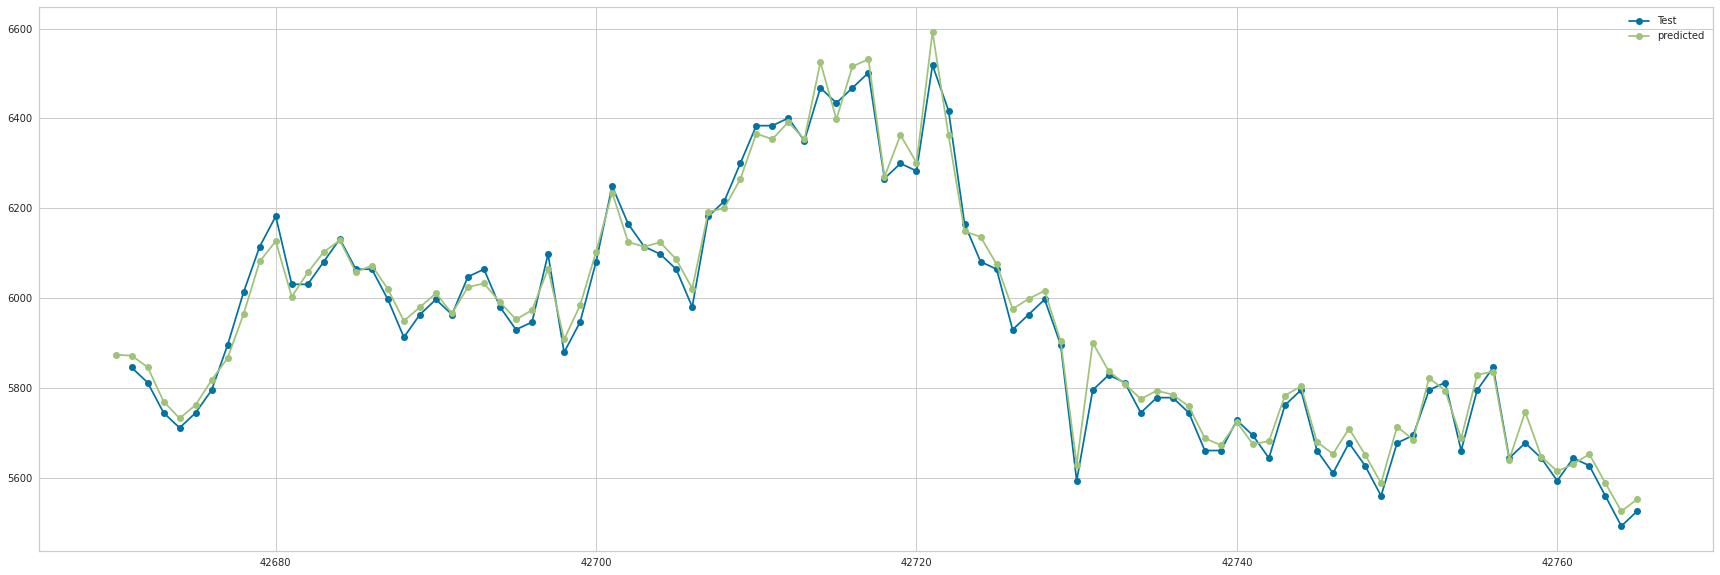

In [21]:
import matplotlib.pyplot as plt
# predict, real 비교 plot
def predict_graph(test,prediction) : 

    #plot
    plt.figure(figsize=(30,10))
    kws = dict(marker='o')
    plt.plot(test, label='Test', **kws)   
    plt.plot(prediction,label='predicted', **kws)
    plt.legend()
    return plt.show()

predict_graph(df_test_t['직전 15분 사용전력'].shift(1),predictions_future['Label'])

feature import


In [17]:
#save the model
save_model(final_best, '/home/ykkim/pipeline_from_AutoML/pycaret/moorim_regression')


Transformation Pipeline and Model Successfully Saved


(ExponentialSmoothing(seasonal='mul', sp=4, trend='add'),
 '/home/ykkim/pipeline_from_AutoML/pycaret/Hansol_3hour_predict.pkl')

In [79]:
loaded_model = load_model('/home/ykkim/pipeline_from_AutoML/pycaret/moorim_regression')
print(loaded_model)

Transformation Pipeline and Model Successfully Loaded
ExponentialSmoothing(seasonal='mul', sp=4, trend='add')


In [80]:
loaded_model.predict()

2022-06-30 00:00    5933.659531
2022-06-30 00:15    5926.247400
2022-06-30 00:30    5935.219384
2022-06-30 00:45    5921.809389
2022-06-30 01:00    5933.493907
2022-06-30 01:15    5926.081982
2022-06-30 01:30    5935.053713
2022-06-30 01:45    5921.644092
2022-06-30 02:00    5933.328282
2022-06-30 02:15    5925.916563
2022-06-30 02:30    5934.888043
2022-06-30 02:45    5921.478794
Freq: 15T, dtype: float64

In [2]:
import pycaret   #pip install --pre pycaret
import sklearn
print(pycaret.__version__)
print(sklearn.__version__)

3.0.0
0.23.2
